## Create and test ion channel model

In [1]:
from channels.icat_markov_testing import (protocols,
                                          conditions,
                                          observations,
                                          simulations,
                                          times,
                                          summary_statistics)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','icat.i_CaT','icat.g']))
        except:
            # Failed simulation
            del(data)
            return None
    return data

def pyabc_simulate(pars):
    res = simulate_model(**pars)
    return res

In [3]:
test = simulate_model()

In [4]:
ss = summary_statistics(test)

## Set limits and generate uniform initial priors

In [6]:
from pyabc import Distribution, RV
limits = {'icat.g_CaT': (0, 10.),
          'icat.p_1': (-50, 50),
          'icat.p_2': (0, 1.),
          'icat.p_3': (-50, 50),
          'icat.p_4': (0, 1.),
          'icat.p_5': (-50, 50),
          'icat.p_6': (0, 1.),
          'icat.p_7': (-50, 50),
          'icat.p_8': (0, 1.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [7]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat_markov_development.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat_markov_development.db


In [8]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [11]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 512 particles


In [18]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=pyabc_simulate,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.001),
             population_size=ConstantPopulationSize(10000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=10000,
             #    mean_cv=0.4,
             #    max_population_size=30000,
             #    min_population_size=pop_size),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 2.446847083869247, '1': 0.8156156946230823, '2': 0.3058558854836559, '3': 0.3495495834098924, '4': 0.18821900645148107, '5': 0.07893055109255653, '6': 0.04531198303461575, '7': 0.03823198568545707, '8': 0.03823198568545707, '9': 0.03823198568545707, '10': 0.037643801290296236, '11': 0.03946527554627827, '12': 0.04369369792623655, '13': 0.040780784731154214, '14': 0.04616692611074057, '15': 0.05319232791020118, '16': 0.05825826390164895, '17': 0.06273966881716028, '18': 0.07893055109255653, '19': 0.08437403737480162, '20': 0.1063846558204022, '21': 0.11651652780329767, '22': 0.10638465582040237, '23': 0.9916618319792545, '24': 1.0743003179775352, '25': 0.9208288439807395, '26': 2.5783207631461034, '27': 3.2229009539326055, '28': 0.6785054639858049, '29': 0.42972012719101194, '30': 0.34842172474946903, '31': 0.37916481810971575, '32': 0.46041442199036975, '33': 0.6445801907865162, '34': 0.8594402543820217, '35': 1.2891603815730421, '36': 1.28916038157

In [19]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [20]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=5, start_time=2019-06-03 08:31:42.926297, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 60227
DEBUG:Epsilon:new eps, t=1, eps=11.045790389051628
INFO:ABC:t:1 eps:11.045790389051628
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 89722
DEBUG:Epsilon:new eps, t=2, eps=11.04442677000465
INFO:ABC:t:2 eps:11.04442677000465
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 132138
DEBUG:Epsilon:new eps, t=3, eps=10.063025673024695
INFO:ABC:t:3 eps:10.063025673024695
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 172414
DEBUG:Epsilon:new eps, t=4, eps=7.7431014908015054
INFO:ABC:t:4 eps:7.7431014908015054
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 209046
DEBUG:Epsilon:new eps, t=5, eps=6.3423048

# Results analysis

In [15]:
from pyabc import History

In [16]:
history = History('sqlite:////scratch/cph211/tmp/hl-1_icat_markov_development.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-05-30 18:07:40.408441, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-05-30 18:10:25.594125, end_time=None)>,
 <ABCSMC(id=3, start_time=2019-06-01 19:02:44.112039, end_time=None)>,
 <ABCSMC(id=4, start_time=2019-06-01 19:35:13.827705, end_time=2019-06-02 22:22:42.886944)>]

In [17]:
history.id = 4

In [18]:
df, w = history.get_distribution(m=0)

In [19]:
df.describe()

name,icat.g_CaT,icat.p_1,icat.p_2,icat.p_3,icat.p_4,icat.p_5,icat.p_6,icat.p_7,icat.p_8
count,5000.000000,5.000000e+03,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.232430,-1.421922e-03,3.630339e-04,-5.871734,0.175539,-4.623145,0.070681,-10.753881,0.073365
std,0.006057,1.176873e-03,2.997346e-04,0.135891,0.003656,0.150865,0.002122,0.162097,0.002946
min,0.227082,-9.099955e-03,4.243544e-08,-6.279441,0.170856,-4.738013,0.067550,-10.917199,0.066254
25%,0.229277,-1.950512e-03,1.327663e-04,-5.854155,0.173571,-4.700539,0.069388,-10.841310,0.074081
50%,0.229885,-1.134223e-03,2.874803e-04,-5.827421,0.174362,-4.687924,0.069942,-10.819846,0.074579
75%,0.230664,-5.512651e-04,5.113797e-04,-5.794177,0.175098,-4.671145,0.070682,-10.790998,0.074943
max,0.247419,-5.239338e-07,2.495142e-03,-5.709942,0.186855,-4.258596,0.077036,-10.353657,0.076275


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make ax

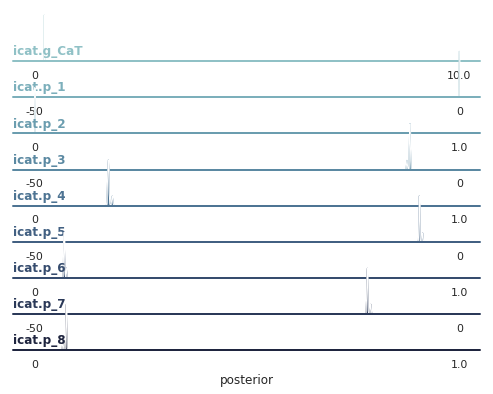

In [20]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

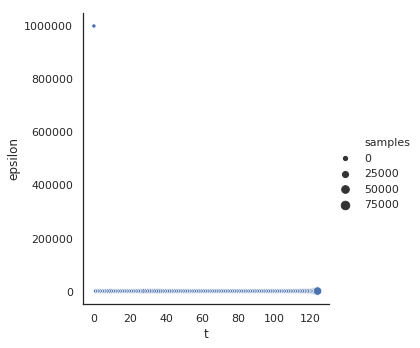

In [48]:
evolution = history.get_all_populations()
g = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
#g.savefig('results/icat-generic/eps_evolution.pdf')

# Samples for quantitative analysis

In [21]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [23]:
plotting_obs = observations.copy()

In [27]:
plotting_obs.rename({'exp_id': 'exp', 'variance': 'errs'}, axis=1, inplace=True)

In [29]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(pyabc_simulate(pars=th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp': plotting_obs.exp})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

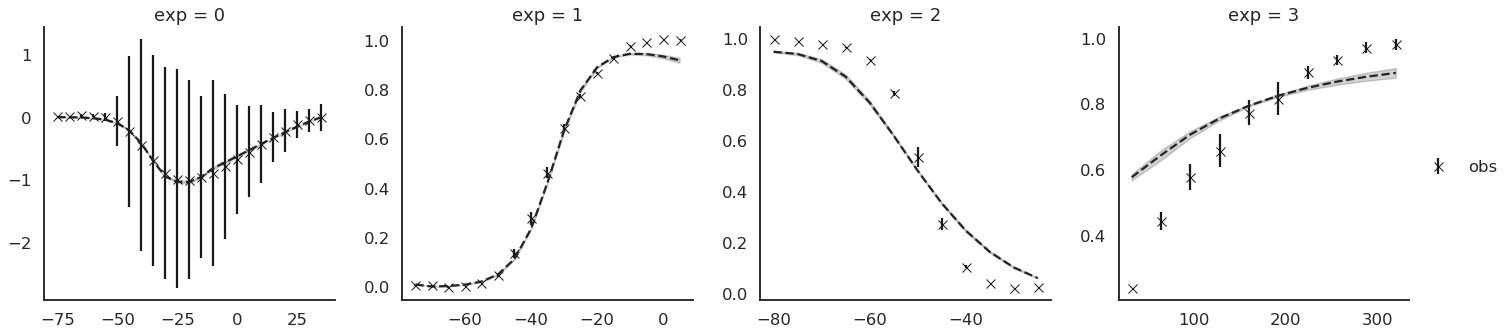

In [31]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=plotting_obs)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [70]:
g.savefig('results/icat-generic/icat_sim_results.pdf')

In [32]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

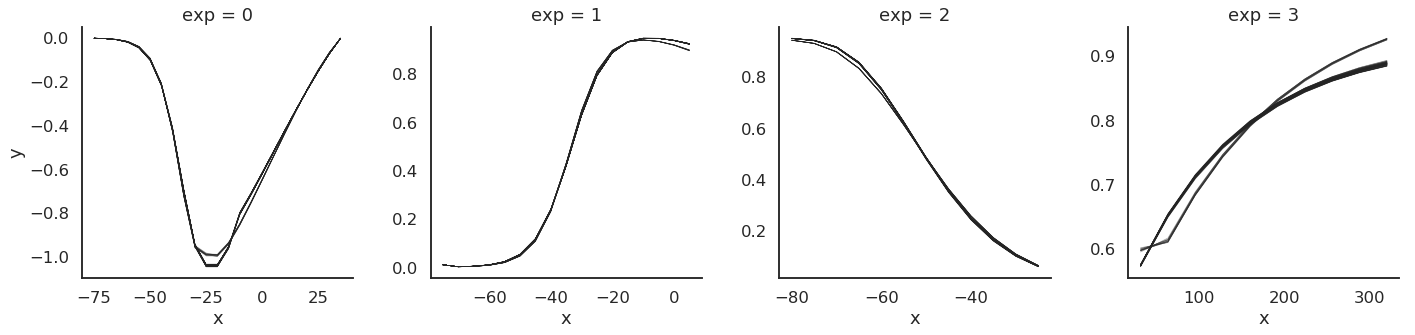

In [33]:
grid2 = plot_sim_results_all(samples)

In [73]:
grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [74]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-12.28849522978163
0.11884277718478846


In [75]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [76]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -12.305081453952692
95% CI: (-12.500217629136861, -12.042063814242947)


In [77]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -21.885714285714286
STD: 1.0634278539232422


In [78]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -21.122448979591837
95% CI: (-23.367346938775512, -21.122448979591837)


In [79]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [80]:
print(np.mean(output))
print(np.std(output))

0   -34.577896
1     5.249907
dtype: float64
0    0.235155
1    0.153233
dtype: float64


In [81]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.58363058983856
95% CI: (-35.0824309590915, -34.05139450727638)


In [82]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.224802366288811
95% CI: (4.983346458403857, 5.580422234103727)


In [83]:
# Half activation potential
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [84]:
print(np.mean(output))
print(np.std(output))

0   -51.099701
1     2.015624
dtype: float64
0    0.324099
1    0.124022
dtype: float64


In [85]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -51.139541001530084
95% CI: (-51.91973135023897, -50.483201273719196)


In [86]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1.9931521591606465
95% CI: (1.7945341598364295, 2.2778268479073294)


In [87]:
# Recovery time constant
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [88]:
print(np.mean(output))
print(np.std(output))

134.15783981052365
6.8765524851314765


In [89]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 134.09052469517178
95% CI: (124.17078543531227, 147.7723663936914)
